# Lab 3
### Using Algorithms and Compute to Identify Clothing Items
Syracuse Applied Data Science, IST-718 Big Data Analytics  

Ryan Timbrook (RTIMBROO)  
DATE: 8/31/2019  
ASSIGNMENT: Lab 3, Week 9  


## Objective
The research question is can we use algorithms and compute to identify clothing items?  Specifically, can we determine **which algorithm and compute methodology** provides us the **most efficient** approach for **classifying** simple fashion images?   

### Instructions:
* Using the base samples available from Zalando Research: 
    * [Fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)   
    * Review the data – clean as appropriate 
    * Provide an initial data analysis 
* Implement at least two approaches for classifying the digits
    * Naïve bayes 
    * Neural Networks 
    * Keras
    * Azure ML  
    * IBM DSX  
    * Boosted trees  
    * Linear classification

#### Answer the following questions:
* What is the accuracy of each method?  
* What are the trade-offs of each approach?  
* What is the compute performance of each approach?  

**Report results for both the training set and the test set.**  

## Findings / Recommendations
place findings and recommendations here  





### --------------------------------------------------------------------------------------------
### Coding Environment Setup
Import packages

In [1]:
# import packages for analysis and modeling
import pandas as pd                            # data frame operations
import numpy as np
import random
import time
import gc
import os
import pickle
from pathlib import Path

import seaborn as sns                          # uses for visualizations
import matplotlib.pyplot as plt                # used for 2D plotting

%matplotlib inline
plt.style.use('fivethirtyeight')


import warnings
from timeit import default_timer               # performance processing time
import logging         

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree   # XGBoost is an optimized distributed gradient boosting library. XGBoost provides a parallel tree boosting (also known as GBDT, GBM)
import xgboost as xgb


In [2]:
# keras Deep Learning packages
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model


Using TensorFlow backend.


In [3]:
# set global properties
# set global environment properties
dataDir = './data/'
dataMnistDir = './data/fashion/'
outputDir = './output/'
configDir = './config/'
logOutDir = './log/'
imageDir = './images/'
modelDir = './models/'
#modelImprovedDir = './models/improved/'
#loggerConfig = 'loggerConfig.yaml'
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL


In [4]:
# custome python packages
import rtimbroo_ist_utils as rt                # custome python helper function
#import evaluate_classifier as evc

In [5]:
# get loggers
warnings.filterwarnings('ignore')
sh_logger = rt.getSHLogger(name='stream_handler',level=loglevel)

## 1.0 OBTAIN the data
Using the base samples available from Zalando Research:
* [Fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)  
* Get the Data:
    * [train-images-idx3-ubyte.gz](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz)  
    * [train-labels-idx1-ubyte.gz](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz)  
    * [t10k-images-idx3-ubyte.gz](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz)  
    * [t10k-labels-idx1-ubyte.gz](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz)  

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.  

Labels
Each training and test example is assigned to one of the following labels:  
  
Label	Description  
    0--->T-shirt/top  
    1--->Trouser  
    2--->Pullover  
    3--->Dress  
    4--->Coat  
    5--->Sandal  
    6--->Shirt  
    7--->Sneaker  
    8--->Bag  
    9--->Ankle boot  

In [6]:
# read in datasets
import mnist_reader # addapted from Zalando Research

X, y = mnist_reader.load_mnist(f'{dataMnistDir}',kind='train')
X_test, y_test = mnist_reader.load_mnist(f'{dataMnistDir}', kind='t10k')

# save off for prediction validation
y_train_labels = y
y_test_labels = y_test



In [8]:
y.shape

(60000,)

In [7]:
features = []
for i in range(1,len(X[0])+1):
    features.append(f'pixel{i}')
features = np.array(features)

In [13]:
# # Each image is 28*28(=784) pixels, hence the 784 features
if sh_logger.info: print(f'MNIST X_train.shape: Row Count [{X.shape[0]}] Column Count: [{X.shape[1]}]')
if sh_logger.info: print(f'MNIST y_train.shape: Row Count [{y.shape[0]}] ')
if sh_logger.info: print(f'MNIST X_trian dtype: [{X.dtype}] y_train dtype: [{y.dtype}]')
if sh_logger.info: print(f'MNIST Testing Set Row Count: [{X_test.shape[0]}] Column Count: [{X_test.shape[1]}]')
if sh_logger.info: print(f'MNIST X_test dtype: [{X_test.dtype}] y_test dtype: [{y_test.dtype}]]')

if sh_logger.info: print(f'Full Training Dataset Info:')
if sh_logger.info: print(f'{np.info(X_train)}\n')
if sh_logger.info: print(f'Full Testing Dataset Info:')
if sh_logger.info: print(f'{np.info(X_test)}\n')  

MNIST X_train.shape: Row Count [60000] Column Count: [784]
MNIST y_train.shape: Row Count [60000] 
MNIST X_trian dtype: [uint8] y_train dtype: [uint8]
MNIST Testing Set Row Count: [10000] Column Count: [784]
MNIST X_test dtype: [uint8] y_test dtype: [uint8]]
Full Training Dataset Info:
class:  ndarray
shape:  (48000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x1be2229c040
byteorder:  little
byteswap:  False
type: uint8
None

Full Testing Dataset Info:
class:  ndarray
shape:  (10000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x1be21b13070
byteorder:  little
byteswap:  False
type: uint8
None



In [14]:
# split validation data to optimize classifier during training
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)


### 1.1 SCRUB / CLEAN
Clean and perform initial transformations steps of the data

### 1.2 EXPLORE
Explore the datasets

In [15]:
# number of label classes, 0 - 9
'''Label Description
0--->T-shirt/top
1--->Trouser
2--->Pullover
3--->Dress
4--->Coat
5--->Sandal
6--->Shirt
7--->Sneaker
8--->Bag
9--->Ankle boot'''
num_classes = 10
class_to_label = {0:'TShirt_Top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'AnkleBoot'}
label_to_class = {'TShirt_Top':0, 'Trouser':1, 'Pullover':2, 'Dress':3, 'Coat':4, 'Sandal':5, 'Shirt':6, 'Sneaker':7, 'Bag':8, 'AnkleBoot':9}
num_pixels = X.shape[1]

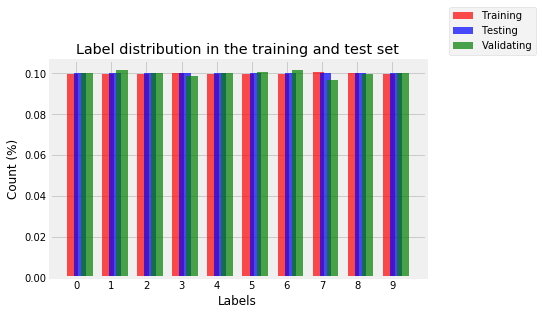

In [16]:
# perform exploratory data analysis techiques
# look at the label balance in training and test sets

# look for imbalance in the sample observations for the class
training_counts = [None] * num_classes
testing_counts = [None] * num_classes
validation_counts = [None] * num_classes

for i in range(num_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)
    validation_counts[i] = len(y_val[y_val==i])/len(y_val)

# plot histogram of the data
train_bar = plt.bar(np.arange(num_classes)-0.1, training_counts, align='center', color = 'r', alpha=0.70, width = 0.33, label='Training')
test_bar = plt.bar(np.arange(num_classes)+0.1, testing_counts, align='center', color = 'b', alpha=0.70, width = 0.33, label = 'Testing')
val_bar = plt.bar(np.arange(num_classes)+0.3, validation_counts, align='center', color = 'g', alpha=0.70, width = 0.33, label = 'Validating')

#plt.figure(figsize=(10.5,7))
plt.xlabel('Labels')
plt.xticks((0,1,2,3,4,5,6,7,8,9))
plt.ylabel('Count (%)')
plt.title('Label distribution in the training and test set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar, val_bar], loc=3)
plt.grid(True)
plt.savefig(f'{imageDir}explore_label_distribution.png', dpi=300)
plt.show()

<Figure size 756x504 with 0 Axes>

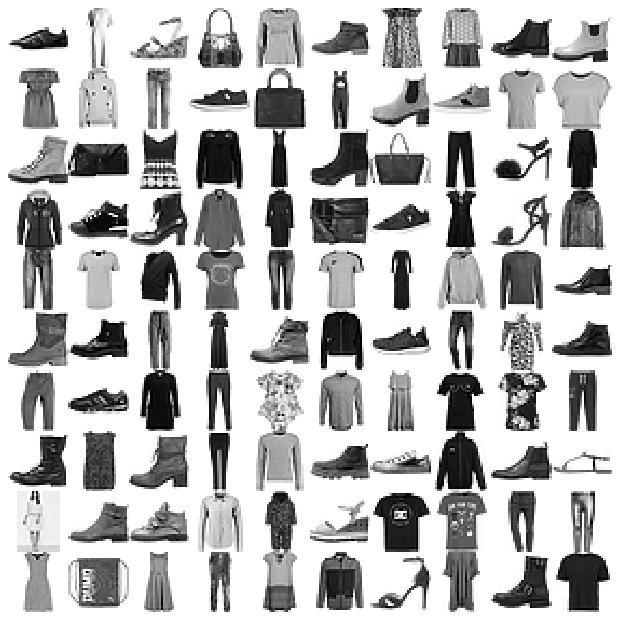

<Figure size 432x288 with 0 Axes>

In [17]:
# plot a sample of the images being trained on
##set up the parameters
plt.figure(figsize=(10.5,7))
example_images = X_train[:100]
rt.plot_sample_images(example_images, images_per_row=10)
plt.savefig(f'{imageDir}explore_sample_images.png', dpi=300)
plt.show()

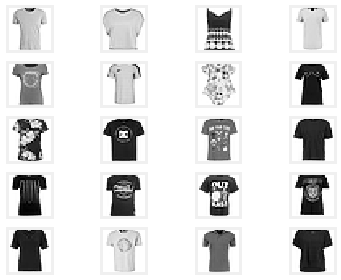

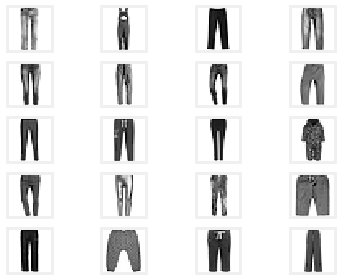

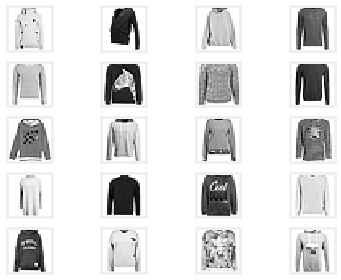

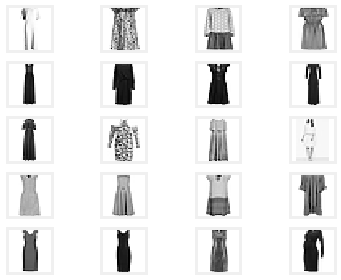

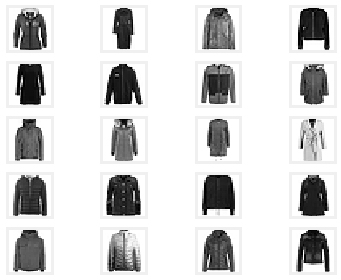

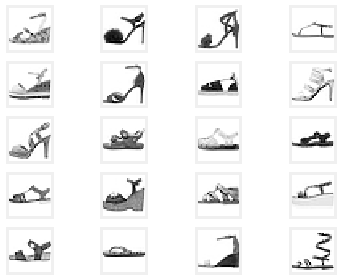

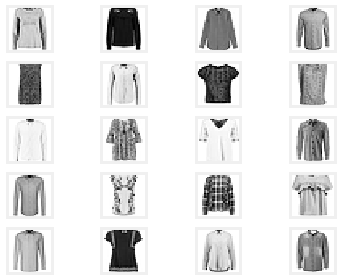

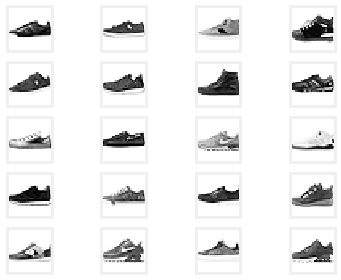

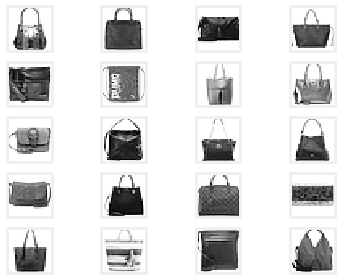

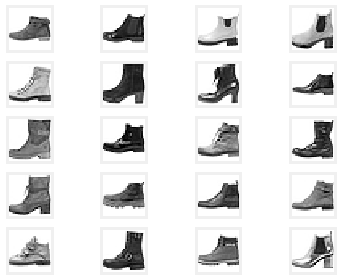

In [18]:
# look at differenct variations of the same image
#plt.figure(figsize=(10, 7.5))
imageName = 'class_images.png'
#imageType = 6
for i in range(num_classes):
    saveImage = f'{i}_{imageName}'
    rt.visualize_image_variations(X_train, y_train, i, 20, (28,28), f'{imageDir}{saveImage}.png')

### One Hot Encode Sequence Data
See [reference](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/) for more details...   
Machine learning algorithms cannot work with categorical data directly.  
Categorical data must be converted to numbers.  

This applies when you are working with a sequence classification type problem and plan on using deep learning methods such as Long Short-Term Memory recurrent neural networks.  

In [19]:
y_test.dtype

dtype('uint8')

In [20]:
# normalize the data set to 0-to-1 range
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
# normalize inputs from RGB color to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

# save off for CNN
y_train_nn = y_train.copy()
y_val_nn = y_val.copy()
y_test_nn = y_test.copy()

# one hot encoding
lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train).astype('int32')
y_val = lbe.fit_transform(y_val).astype('int32')


# input shape
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [21]:
y_train.dtype

dtype('int32')

## 2.0 Modeling Functions
Notebook functions have been moved to the **rtimbroo_ist_utils.py** for common reuse and notebook readability.   

In [22]:
# modeling programming variables
# perform model creation and validation techniques
modelsPerformance = {'ModelName':[], 
                     'TestAccuracyScore':[],
                     'PredictAccuracyScore':[] ,
                     'TrainTime':[], 
                     'TestTime':[],
                     'ScoreTime':[], 
                     'PredictTime':[]
                     }
# labels used for plotting
labels = [l for l in class_to_label.keys()]

## 2.0 MODEL - RandomForestClassifier
-----------------------------------------------------------------------------
Python Package: scikit-learn v0.21.3 [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).  



### 2.1 Create Models - RandomForestClassifier
 
#### Random Forest Attributes
See scikit learn [glossary](https://scikit-learn.org/stable/glossary.html#term-warm-start) for indepth details. 

#### 2.1 Model Build

In [23]:
# instantiate base class - accepting default attributes
rf_base = RandomForestClassifier(n_estimators=100,             # The number of trees in the forest.
                                 criterion="gini",             # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
                                 max_depth=None,               # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                 min_samples_split=2,          # The minimum number of samples required to split an internal node
                                 min_samples_leaf=1,           # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches
                                 min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
                                 max_features="auto",          # The number of features to consider when looking for the best split: If “auto”, then max_features=sqrt(n_features).
                                 max_leaf_nodes=None,          # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                                 min_impurity_decrease=0.0,    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                 min_impurity_split=None,      # Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
                                 bootstrap=True,               # Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
                                 oob_score=False,              # Whether to use out-of-bag samples to estimate the generalization accuracy.
                                 n_jobs=None,                  # The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 random_state=None,            # if int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random
                                 verbose=2,                    # Controls the verbosity when fitting and predicting.
                                 warm_start=False,             # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                                 class_weight=None             # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                )


#### 2.2 Model Train / Validate / Score

In [ ]:
# Construct Baseline
rf = rt.train_validate_classifier(rf_base, 'rf_base', X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)


In [24]:
# reading model in from file
import pickle

with open(f'{modelDir}rf_base','rb') as f:
    rf = pickle.load(f)
    
with open(f'{modelDir}rf_base_fit','rb') as f:
    rf_base_fit = pickle.load(f)

In [28]:
rf_base_fit.get_params(deep=True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': False}

#### 2.3 Model Predict / Score

In [25]:
rf_pred = rt.predict_classifier(rf, 'rf_base', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)
#rf_pred

Starting Model Prediction at time: 20:24:41.360443



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


Complete Model Prediction - Execution Time: [0.5973011999999471]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1274, 2)
Miss Classified Percent: 0.1274
Total Number of points: [10000]  Mislabeled Points: [1274]
Percent Accurately Labeled: [0.8726]
Accuracy Score: [0.8726]

              precision    recall  f1-score   support

      Class0       0.82      0.85      0.83      1000
      Class1       0.99      0.96      0.97      1000
      Class2       0.75      0.81      0.78      1000
      Class3       0.87      0.90      0.88      1000
      Class4       0.76      0.81      0.78      1000
      Class5       0.98      0.96      0.97      1000
      Class6       0.71      0.57      0.64      1000
      Class7       0.93      0.95      0.94      1000
      Class8       0.96      0.97      0.96      1000
      Class9       0.95      0.94 

In [26]:
with open(f'{modelDir}rf_base_predictions','rb') as f:
    rf_pred = pickle.load(f)

#### 2.4 Model Evaluate

      feature  importance
574  pixel575    0.009956
602  pixel603    0.009318
490  pixel491    0.007860
546  pixel547    0.007573
611  pixel612    0.006954
518  pixel519    0.006905
462  pixel463    0.006731
406  pixel407    0.006226
67    pixel68    0.005271
207  pixel208    0.005022


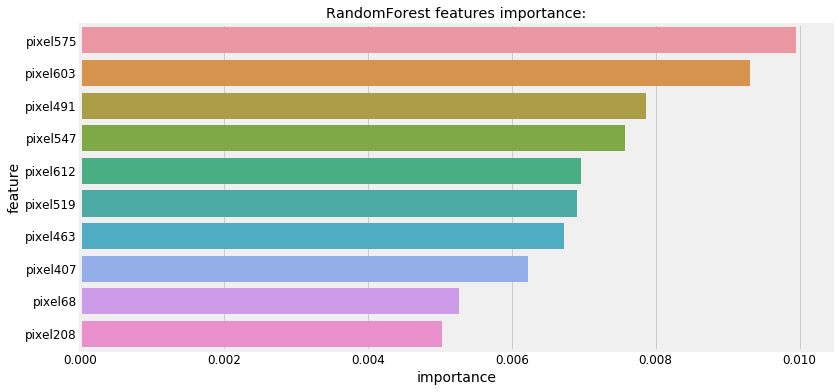

In [27]:
# Random Forest - Feature importance
rt.feature_importances(features, rf, 'RandomForest', sh_logger)

In [ ]:
# returns best predictor from the cross fold training process
#rf_base_cv = rt.trainWithCrossValidate(rf, 'rf_base_cv', X_train, y_train, modelsPerformance, sh_logger, modelDir)

In [29]:
# reading model in from file
import pickle

with open(f'{modelDir}rf_base_cv_cv','rb') as f:
    rf_base_cv = pickle.load(f)

In [30]:
# use best CV to predict unseen dataset
rf_base_cv_pred = rt.predict_classifier(rf_base_cv, 'rf_base_cv', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 20:28:57.348097



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Complete Model Prediction - Execution Time: [0.5592024000000038]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1274, 2)
Miss Classified Percent: 0.1274
Total Number of points: [10000]  Mislabeled Points: [1274]
Percent Accurately Labeled: [0.8726]
Accuracy Score: [0.8726]

              precision    recall  f1-score   support

      Class0       0.82      0.85      0.83      1000
      Class1       0.99      0.96      0.97      1000
      Class2       0.75      0.81      0.78      1000
      Class3       0.87      0.90      0.88      1000
      Class4       0.76      0.81      0.78      1000
      Class5       0.98      0.96      0.97      1000
      Class6       0.71      0.57      0.64      1000
      Class7       0.93      0.95      0.94      1000
      Class8       0.96      0.97      0.96      1000
      Class9       0.95      0.94 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [31]:
import pickle

with open(f'{modelDir}rf_base_cv_predictions','rb') as f:
    rf_base_cv_pred = pickle.load(f)

In [ ]:
# plot out sample images from the classes that scored lower than 90%

#### 2.5 Model Tune

In [32]:
rfTuneTrialIndex = 0

In [33]:
# instantiate base class - accepting default attributes
rf_ = RandomForestClassifier(n_estimators=200,             # The number of trees in the forest.
                                 criterion="gini",             # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
                                 max_depth=10,               # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                 min_samples_split=2,          # The minimum number of samples required to split an internal node
                                 min_samples_leaf=1,           # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches
                                 min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
                                 max_features="auto",          # The number of features to consider when looking for the best split: If “auto”, then max_features=sqrt(n_features).
                                 max_leaf_nodes=None,          # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                                 min_impurity_decrease=0.0,    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                 min_impurity_split=None,      # Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
                                 bootstrap=True,               # Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
                                 oob_score=False,              # Whether to use out-of-bag samples to estimate the generalization accuracy.
                                 n_jobs=5,                     # The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 random_state=42,              # if int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random
                                 verbose=0,                    # Controls the verbosity when fitting and predicting.
                                 warm_start=False,             # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                                 class_weight=None             # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                )

In [ ]:
# run validation on tunning parameters
rfTuneTrialIndex = rfTuneTrialIndex + 1
rf = rt.train_validate_classifier(rf_, f'rf_tun_{rfTuneTrialIndex}', X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)


In [34]:
# reading model in from file
import pickle
rfTuneTrialIndex = rfTuneTrialIndex + 1 # only use this line after training, and kernel restarted
with open(f'{modelDir}rf_tun_{rfTuneTrialIndex}','rb') as f:
    rf = pickle.load(f)
    
with open(f'{modelDir}rf_tun_{rfTuneTrialIndex}_fit','rb') as f:
    rf_tun_fit = pickle.load(f)

In [37]:
rf_tun_fit.get_params(deep=True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': 5,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [36]:
rf_pred = rt.predict_classifier(rf, f'rf_tun_{rfTuneTrialIndex}', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 20:30:33.063960

Complete Model Prediction - Execution Time: [0.32325649999995676]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1565, 2)
Miss Classified Percent: 0.1565
Total Number of points: [10000]  Mislabeled Points: [1565]
Percent Accurately Labeled: [0.8435]
Accuracy Score: [0.8435]

              precision    recall  f1-score   support

      Class0       0.80      0.83      0.81      1000
      Class1       0.99      0.94      0.96      1000
      Class2       0.71      0.73      0.72      1000
      Class3       0.82      0.90      0.86      1000
      Class4       0.68      0.80      0.74      1000
      Class5       0.98      0.93      0.95      1000
      Class6       0.70      0.49      0.58      1000
      Class7       0.89      0.92      0.91      1000
      Class8       0.95      0.96  

#### 2.6 Model Evaluate Tuned Parameters

## 3.0 Model - Boosted Tree
### XGBoost
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting.   

See documentation for more indepth details.
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/)    
* [XGBoost Parameter details](https://xgboost.readthedocs.io/en/latest/parameter.html)  
* [XGBClassifier Example](https://www.programcreek.com/python/example/99824/xgboost.XGBClassifier)   


In [38]:
# initialize a base-line xgboost object
xgbc_base = XGBClassifier(
                        n_estimators=50, 
                        max_depth=5
                        )

#### 3.1 Model - Train / Validate / Score

In [ ]:
# Construct Baseline
#modelsPerformance['ModelName'].append('xgbc_base')
xgbc_base = rt.train_validate_classifier(xgbc_base, 'xgbc_base', X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)


In [39]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbc_base','rb') as f:
    xgbc_base = pickle.load(f)
    
with open(f'{modelDir}xgbc_base_fit','rb') as f:
    xgbc_base_fit = pickle.load(f)

In [43]:
xgbc_base_fit.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'nthread': 1,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

#### 3.2 Model - Predict / Score

In [40]:
xgbc_pred = rt.predict_classifier(xgbc_base, 'xgbc_base', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 20:32:18.538209

Complete Model Prediction - Execution Time: [0.18395929999996952]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1391, 2)
Miss Classified Percent: 0.1391
Total Number of points: [10000]  Mislabeled Points: [1391]
Percent Accurately Labeled: [0.8609]
Accuracy Score: [0.8609]

              precision    recall  f1-score   support

      Class0       0.80      0.84      0.82      1000
      Class1       0.99      0.95      0.97      1000
      Class2       0.75      0.77      0.76      1000
      Class3       0.85      0.89      0.87      1000
      Class4       0.74      0.79      0.77      1000
      Class5       0.98      0.94      0.96      1000
      Class6       0.67      0.56      0.61      1000
      Class7       0.92      0.94      0.93      1000
      Class8       0.95      0.96  

In [44]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbc_base_predictions','rb') as f:
    xgbc_pred = pickle.load(f)

#### 3.3 Model - Evaluate

      feature  importance
346  pixel347    0.044827
627  pixel628    0.029445
733  pixel734    0.026836
655  pixel656    0.026720
407  pixel408    0.025823
490  pixel491    0.023035
471  pixel472    0.022276
499  pixel500    0.021924
117  pixel118    0.019886
339  pixel340    0.017785


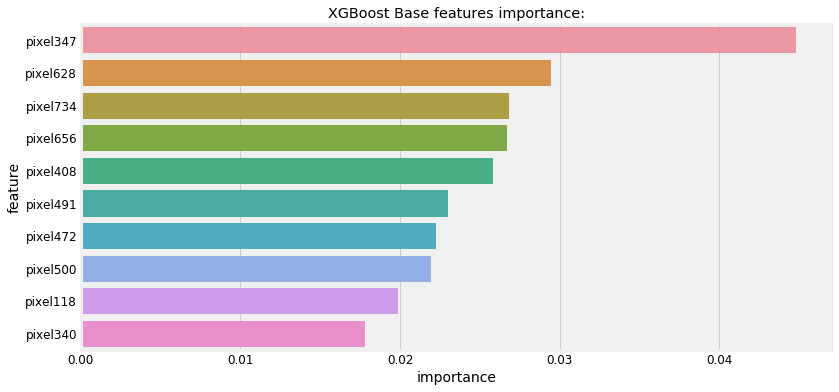

In [45]:
# XGBoost - Feature importance
rt.feature_importances(features, xgbc_base, 'XGBoost Base', sh_logger)

In [47]:
#modelsPerformance

#### 3.3 Model - Tune

In [48]:
#XGBoost with GridSearch
gridParameters = [{
    'max_depth':[5,10],
    'n_estimators':[100],
    'learning_rate':[0.05, 0.1],
    'colsample_bytree':[0.8, 0.95]
}]

# instantiate classifier object
xgbs_gs = XGBClassifier(random_state=42)

In [ ]:
# execute grid search on XGBoost object - performs training, testing on validation data and scorring
xgbc_gs = rt.grid_search(xgbs_gs, 'xgbs_gs', gridParameters, X_train, y_train, X_val, y_val, modelsPerformance, sh_logger, modelDir, num_classes, labels)

In [50]:
# reading model in from file
import pickle

with open(f'{modelDir}xgbs_gs','rb') as f:
    xgbc_gs = pickle.load(f)

In [52]:
xgbc_gs.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'subsample': 1,
 'verbosity': 1}

In [51]:
# run prediction on the unseen test dataset
xgbc_gs_pred = rt.predict_classifier(xgbc_gs, 'xgbc_gs', X_test, y_test, modelsPerformance, sh_logger, num_classes, labels, modelDir)


Starting Model Prediction at time: 20:36:10.499777

Complete Model Prediction - Execution Time: [0.35004049999997733]

Classification DF Shape: (10000, 2)
 Head:
   Label  Prediction
0      9           9
1      2           2
2      1           1
3      1           1
4      6           6
Miss Classified DF Shape: (1133, 2)
Miss Classified Percent: 0.1133
Total Number of points: [10000]  Mislabeled Points: [1133]
Percent Accurately Labeled: [0.8867]
Accuracy Score: [0.8867]

              precision    recall  f1-score   support

      Class0       0.83      0.86      0.84      1000
      Class1       0.99      0.97      0.98      1000
      Class2       0.79      0.82      0.80      1000
      Class3       0.89      0.91      0.90      1000
      Class4       0.80      0.82      0.81      1000
      Class5       0.98      0.96      0.97      1000
      Class6       0.72      0.63      0.67      1000
      Class7       0.94      0.96      0.95      1000
      Class8       0.97      0.97  

In [54]:
# reading model in from file
#import pickle

#with open(f'{modelDir}xgbs_gs_predictions','rb') as f:
    #xgbc_gs_pred = pickle.load(f)

#### 3.4 Model - Evaluate Tuned Parameters

      feature  importance
337  pixel338    0.039395
346  pixel347    0.038740
471  pixel472    0.033826
339  pixel340    0.032541
655  pixel656    0.028037
490  pixel491    0.025547
733  pixel734    0.021477
117  pixel118    0.021126
627  pixel628    0.018149
178  pixel179    0.016589


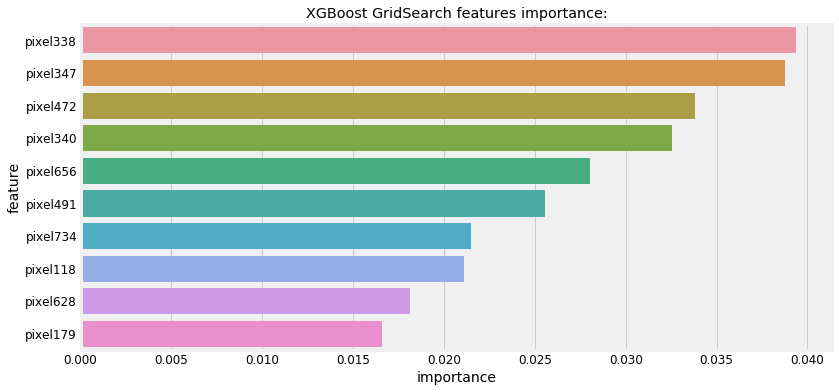

In [55]:
# XGBoost - Feature importance
rt.feature_importances(features, xgbc_gs, 'XGBoost GridSearch', sh_logger)

In [ ]:
# fix TestTime - CV function didn't update - set to zero
modelsPerformance['TestTime'] = [0.6415216000000044,0.0,0.43304430000000593,0.6098084000000199,1.900499299998046]
mp = pd.DataFrame(modelsPerformance)
mp.to_csv(f'{dataDir}models_performance.csv', index=False)
mp

## 4.0 Model - CNN with Keras
Python package: [keras](https://keras.io/)   
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation.  

* Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).  
* Supports both convolutional networks and recurrent networks, as well as combinations of the two.  
* Runs seamlessly on CPU and GPU.  

### 4.1 Baseline Neural Network Model

In [56]:
# one hot encoding - convert class vectores to binary class matrices
# This means that a column will be created for each output category 
#  and a binary variable is inputted for each category.

y_train = np_utils.to_categorical(y_train_nn, 10)
y_test = np_utils.to_categorical(y_test_nn, 10)
y_val = np_utils.to_categorical(y_val_nn, 10)

References:
* optimizer - [adam](https://arxiv.org/abs/1412.6980v8)   
* loss - [categorical_crossentropy](https://keras.io/backend/#categorical_crossentropy) 
* activation - [softmax](https://keras.io/activations/#softmax)   

In [57]:
# Model - Build the baseline
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    # Compile model loss - categorical_crossentropy - used for identifing multiple images
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

In [58]:
nn_base = baseline_model()
nn_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


#### 4.1.1 Model Build

In [ ]:
# create baseline model
epochs=300
batch_size=1000
verbose=2
t = 0.0
nn_base = baseline_model()
with rt.elapsed_timer() as elapsed:
    
    # fit the model
    nn_base_hist = nn_base.fit(X_train, y_train, validation_data=(X_val, y_val),shuffle=True,
                                         epochs=epochs, batch_size=batch_size, verbose=verbose) 
    t = elapsed()
    if sh_logger.info: print(f'Base NN Build model time: [{t}]')
    
    #save model to file
    with open(modelDir+'nn_base_model','wb') as f:
        pickle.dump(nn_base,f)
    
    with open(modelDir+'nn_base_hist','wb') as f:
        pickle.dump(nn_base_hist,f)

    # save neurl network to file
    from pathlib import Path
    modelFileName = 'nn_base.json'
    model_structure = nn_base.to_json()
    f = Path(f'{modelDir}{modelFileName}')
    f.write_text(model_structure)

    # save neural network trained weights
    modelFileH5 = 'nn_base.h5'
    nn_base.save_weights(f'{modelDir}{modelFileH5}')

# keep track of each model's performance metrics
modelsPerformance['ModelName'].append('nn_base')
modelsPerformance['TrainTime'].append(t)

#### 4.1.2 Model Score

In [60]:
# reading model in from file and plotting
import pickle

with open(f'{modelDir}nn_base_model','rb') as f:
    nn_base = pickle.load(f)
    
with open(f'{modelDir}nn_base_hist','rb') as f:
    nn_base_hist = pickle.load(f)

In [ ]:
# plot model
#import graphviz
#modelSaveName = 'nn_base.png'
#plot_model(nn_base, to_file=f'{imageDir}{modelSaveName}')

In [61]:
t = 0.0
with rt.elapsed_timer() as elapsed:
    
    nn_base_scores = nn_base.evaluate(X_test, y_test, verbose=0)
    t = elapsed()
    test_loss = nn_base_scores[0]
    test_accuracy = nn_base_scores[1]
    if sh_logger.info: print(f'Test loss: {test_loss}')
    if sh_logger.info: print(f'Test accuracy: {test_accuracy}')
    if sh_logger.info: print(f'Baseline Error: {(100-nn_base_scores[1]*100)}')

modelsPerformance['ScoreTime'].append(t)
modelsPerformance['TestAccuracyScore'].append(test_accuracy)

Test loss: 0.6372586319293827
Test accuracy: 0.8974
Baseline Error: 10.260000000000005


In [62]:
nn_base_scores

[0.6372586319293827, 0.8974]

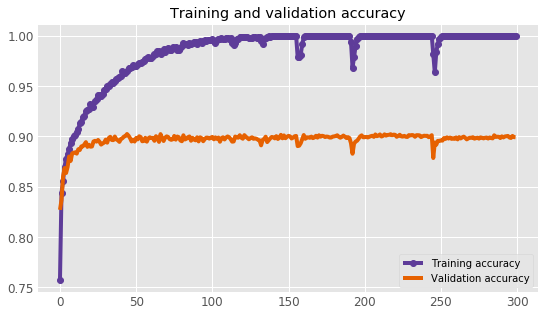

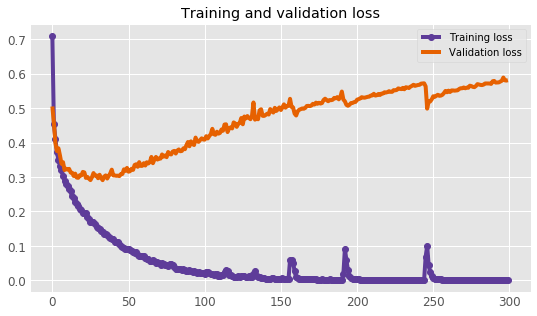

In [63]:
# plot training and validation accuracy
rt.plot_nn_training_curve(nn_base_hist,f'{imageDir}nn_base_training_validation_accuracy')

In [65]:
#nn_base.
nn_base_hist.params

{'batch_size': 1000,
 'epochs': 300,
 'steps': None,
 'samples': 48000,
 'verbose': 2,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

#### 4.1.3 Model Predict

In [66]:
# training prediction accuracy
y_train_pred = nn_base.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
if sh_logger.info: print(f'Training Accuracy: [%{(acc*100)}]')

Training Accuracy: [%[ 4.43125    10.43125     2.16875     4.82916667  2.55        8.67291667
  2.53541667  9.15208333  8.40833333  7.51458333]]


In [67]:
np.sum(y_train[:10] == y_train_pred[:10], axis=0) 

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 2])

In [68]:
t = 0.0
with rt.elapsed_timer() as elapsed:
    y_test_pred = nn_base.predict_classes(X_test)

modelsPerformance['PredictTime'].append(t)

correct = np.nonzero(y_test_pred==y_test_labels)[0]
incorrect = np.nonzero(y_test_pred!=y_test_labels)[0]

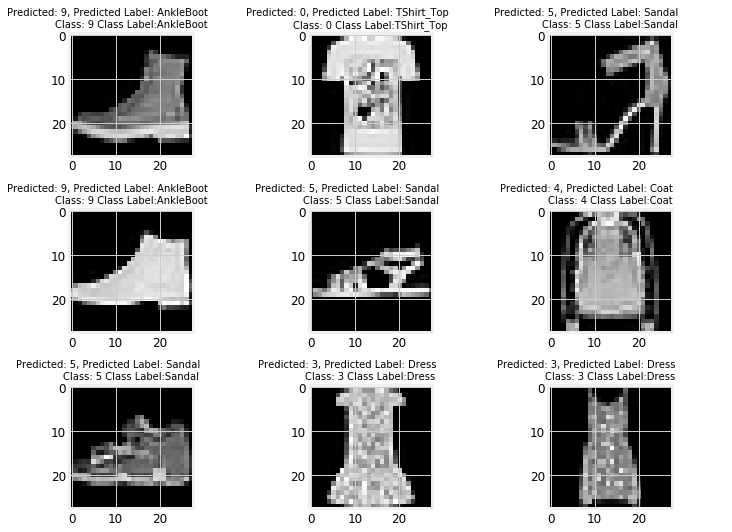

<Figure size 432x288 with 0 Axes>

In [69]:
# sample plot of correctly predicted images
plt.figure(figsize=(10, 7.5))
for i, cor in enumerate(np.random.choice(correct,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[cor].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {y_test_pred[cor]}, Predicted Label: {class_to_label[y_test_pred[cor]]} \
              \nClass: {y_test_labels[cor]} Class Label:{class_to_label[y_test_labels[cor]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}nn_base_sample_correct_images.png', dpi=300)
plt.show()    
plt.tight_layout()
plt.show();

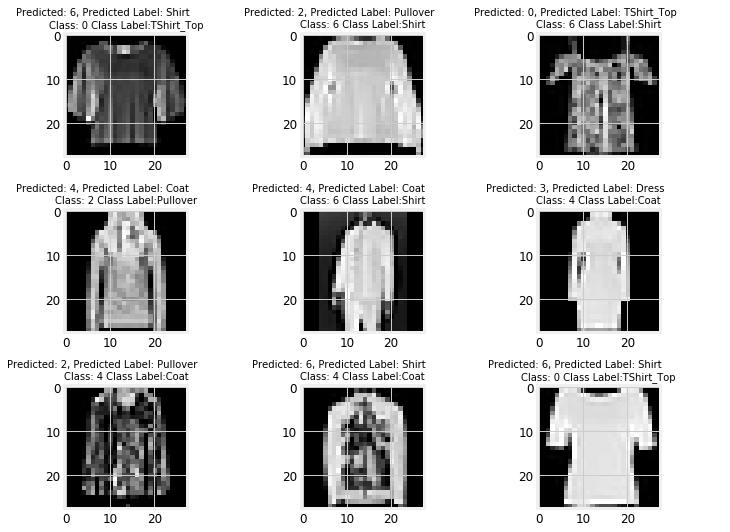

<Figure size 432x288 with 0 Axes>

In [70]:
# plot sample of incorrect
plt.figure(figsize=(10, 7.5))
for i, inc in enumerate(np.random.choice(incorrect,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[inc].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {y_test_pred[inc]}, Predicted Label: {class_to_label[y_test_pred[inc]]} \
              \nClass: {y_test_labels[inc]} Class Label:{class_to_label[y_test_labels[inc]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}nn_base_sample_incorrect_images.png', dpi=300)
plt.show()    
plt.tight_layout()
plt.show();

In [71]:
c6_inc = [inc for inc in incorrect if y_test_pred[inc] == 6]
c6_prints = 0

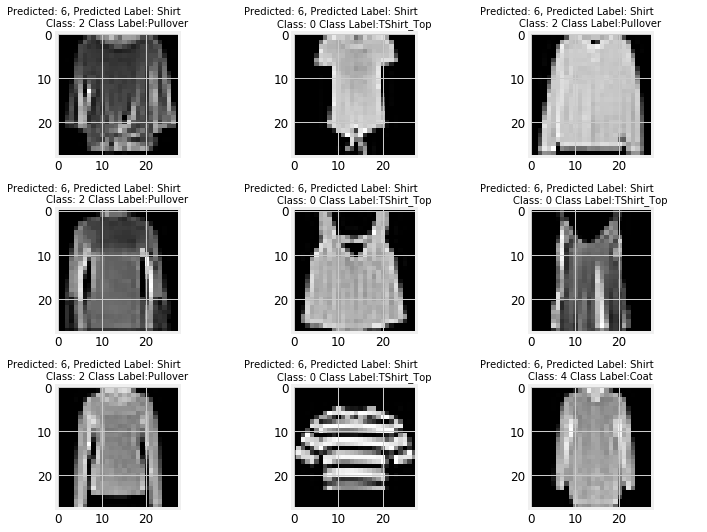

<Figure size 432x288 with 0 Axes>

In [72]:
# plot sample of incorrect prediction of class 6
c6_prints = c6_prints + 1
plt.figure(figsize=(10, 7.5))
for i, inc in enumerate(np.random.choice(c6_inc,9,replace=False)):
    
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[inc].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {y_test_pred[inc]}, Predicted Label: {class_to_label[y_test_pred[inc]]} \
              \nClass: {y_test_labels[inc]} Class Label:{class_to_label[y_test_labels[inc]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}c6_nn_base_sample_incorrect_images_{c6_prints}.png', dpi=300)
plt.show()    
plt.tight_layout()
plt.show();

In [73]:
# Test Prediction Accuracy
base_test_pred_table = pd.DataFrame({'True_Test_Labels':y_test_pred, 'Predicted_Test_Labels':y_test_labels})
if sh_logger.info: print(f'Test Prediction shape: {base_test_pred_table.shape}')
if sh_logger.debug: print(f'Test Prediction Table Head:\n{base_test_pred_table.head()}')
    
# make table of miss labeled images
missLabeledTestImages = base_test_pred_table.loc[~(base_test_pred_table['True_Test_Labels'] == base_test_pred_table['Predicted_Test_Labels'])]
if sh_logger.info: print(f'Test Prediction Miss Labeled shape: {missLabeledTestImages.shape}')
if sh_logger.debug: print(f'Test Prediction Miss Labeled Head:\n{missLabeledTestImages.head()}')

# percent accuracy of labeled images
predictAccuracyScore = 100 - (missLabeledTestImages.shape[0]/base_test_pred_table.shape[0]*100)
if sh_logger.info: print(f'Test Prediction Error: {missLabeledTestImages.shape[0]/base_test_pred_table.shape[0]*100}%')
if sh_logger.info: print(f'Test Prediction Accuracy: {predictAccuracyScore}%')

    
    
targetNames = ["Class{}".format(i) for i in range(num_classes)]
if sh_logger.info: print(f'\n{classification_report(y_test_labels, y_test_pred, target_names=targetNames)}')   

modelsPerformance['PredictAccuracyScore'].append(predictAccuracyScore/100)

Test Prediction shape: (10000, 2)
Test Prediction Table Head:
   True_Test_Labels  Predicted_Test_Labels
0                 9                      9
1                 2                      2
2                 1                      1
3                 1                      1
4                 6                      6
Test Prediction Miss Labeled shape: (1026, 2)
Test Prediction Miss Labeled Head:
    True_Test_Labels  Predicted_Test_Labels
12                 5                      7
23                 5                      9
25                 6                      4
40                 0                      6
42                 6                      3
Test Prediction Error: 10.26%
Test Prediction Accuracy: 89.74%

              precision    recall  f1-score   support

      Class0       0.84      0.84      0.84      1000
      Class1       0.99      0.97      0.98      1000
      Class2       0.82      0.82      0.82      1000
      Class3       0.91      0.89      0.90      1000


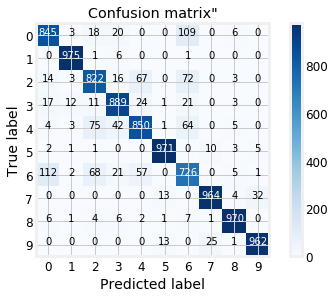

In [74]:
# confusion matrix evaluation
cm = confusion_matrix(base_test_pred_table.iloc[:,0],base_test_pred_table.iloc[:,1], labels=[0,1,2,3,4,5,6,7,8,9])
rt.plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9], f'{imageDir}nn_base_confusion_matrix.png')

#### 4.1.4 Model Evaluate

In [ ]:
modelsPerformance['TestTime'] = 0.0

### 4.2 Convelutional Neural Network Model

Deciding on 3x3 as the optimal kernel size for CNN, see [here](https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363) for details.  

#### 4.2.1 Build CCN Model

In [75]:
# Model - Build the baseline
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1) # image shape - 1 signifies the images are in greyscale

def cnn_model():
    # create model
    #input image dimensions
   

    model = Sequential()
    # 1st convelutional layer - work with imput images, which are seen as 2-dimensional matrices
    model.add(Conv2D(28, kernel_size=3 ,padding='same', activation='relu', 
                     kernel_initializer='he_normal',
                     input_shape=input_shape))
    model.add(MaxPooling2D((2, 2))) # down sample data, only pass on the important stuff
    model.add(Dropout(0.25)) # prevent nn from memorizing the training data - cut nn connections
    
    # 2nd convelutional layer
    model.add(Conv2D(64, kernel_size=3 ,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # down sample data, only pass on the important stuff
    model.add(Dropout(0.25)) # prevent nn from memorizing the training data - cut nn connections
    
    # 3rd convelutional layer
    model.add(Conv2D(128, kernel_size=3 , activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Flatten()) # tells kerras it's not working with 2D data anymore
    model.add(Dense(num_pixels, activation='relu')) # map classes
    model.add(Dropout(0.3))
    
    # output layer
    model.add(Dense(num_classes, activation='softmax')) # map classes
     
     
    # Compile model loss - categorical_crossentropy - used for identifing multiple images
    # Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.
    # ‘categorical_crossentropy’ for our loss function. This is the most common choice for classification. 
    #     A lower score indicates that the model is performing better.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

In [76]:
# build model and look at it's structure
cnn = cnn_model()
cnn.summary()
# total numuber of parameter's is the number of weights

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        16192     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
___________________________

In [77]:
X_train.shape

(48000, 784)

In [78]:
# reshape training and test data for cnn input
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_train.shape

(48000, 28, 28, 1)

In [ ]:
# fit the model, get the history object that we can use to plot training vs validation accuracy and loss
epochs=300
batch_size=1000
verbose=2
t = 0.0
with rt.elapsed_timer() as elapsed:
    
    cnn_hist = cnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
    t = elapsed()
    
    # save neurl network to file
    #save model to file
    with open(modelDir+'cnn','wb') as f:
        pickle.dump(cnn,f)
    
    with open(modelDir+'cnn_hist','wb') as f:
        pickle.dump(cnn_hist,f)
    
    
    from pathlib import Path
    modelFileName = 'cnn.json'
    model_structure = cnn.to_json()
    f = Path(f'{modelDir}{modelFileName}')
    f.write_text(model_structure)

    # save neural network trained weights
    modelFileH5 = 'cnn.h5'
    cnn.save_weights(f'{modelDir}{modelFileH5}')
    

# keep track of each model's performance metrics
modelsPerformance['ModelName'].append('CNN')
modelsPerformance['TrainTime'].append(t)

In [79]:
# load cnn json model from path
from keras.models import model_from_json

f = Path(f'{modelDir}cnn.json')
cnn_model_structure = f.read_text()
cnn = model_from_json(cnn_model_structure)

# re-compile the model
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# reload cnn model weights
cnn.load_weights(f'{modelDir}cnn.h5')

# reinstantiate the cnn model
#cnn_cfg = cnn.get_config()
#cnn = cnn.from_config(cnn_cfg)


# load the cnn hist file for plotting and evaluation
with open(f'{modelDir}cnn_hist','rb') as f:
    cnn_hist = pickle.load(f)

In [80]:
#cnn_cfg = cnn.get_config()
#cnn = cnn.from_config(cnn_cfg)
cnn.get_weights()
#cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

[array([[[[ 2.13313490e-01, -7.73864836e-02, -4.33116317e-01,
            1.58590272e-01, -7.40049243e-01, -3.97068053e-01,
           -2.79766042e-04, -5.35423830e-02,  7.33222067e-01,
           -7.18823016e-01, -1.00646235e-01,  6.43016219e-01,
           -9.13414359e-01,  5.27233705e-02, -9.05315518e-01,
            1.07007170e+00, -1.27768770e-01, -5.30547857e-01,
           -3.29055339e-01,  8.41181993e-01, -3.50011177e-02,
           -2.75798142e-01,  1.01248813e+00,  4.41623211e-01,
           -9.20686498e-02, -8.29144180e-01,  9.14425135e-01,
           -8.72227103e-02]],
 
         [[-5.38843721e-02,  5.37557721e-01, -2.62465030e-01,
            5.11315130e-02,  7.26748586e-01, -2.47401908e-01,
           -7.46663332e-01, -6.00928485e-01, -8.07002902e-01,
           -1.04223990e+00,  9.50877726e-01, -3.28977853e-01,
            2.14603364e-01, -8.00108016e-01, -3.77814054e-01,
           -1.31494030e-01, -2.01926187e-01, -8.39796066e-02,
            3.56417626e-01, -4.7141125

In [81]:
# evaluate CNN get accuracy scores on held out, unseen test data
t = 0.0
with rt.elapsed_timer() as elapsed:
    
    cnn_score = cnn.evaluate(X_test, y_test, verbose=0)
    t = elapsed()

    test_loss = cnn_score[0]
    test_accuracy = cnn_score[1]
    if sh_logger.info: print(f'Test loss: {test_loss}')
    if sh_logger.info: print(f'Test accuracy: {test_accuracy}')
    if sh_logger.info: print(f'CNN Error: {(100-cnn_score[1]*100)}')

modelsPerformance['ScoreTime'].append(t)
modelsPerformance['TestAccuracyScore'].append(test_accuracy)
    
print('Test loss:', cnn_score[0])
print('Test accuracy:', cnn_score[1])

Test loss: 0.3705837944106199
Test accuracy: 0.9314
CNN Error: 6.859999999999999
Test loss: 0.3705837944106199
Test accuracy: 0.9314


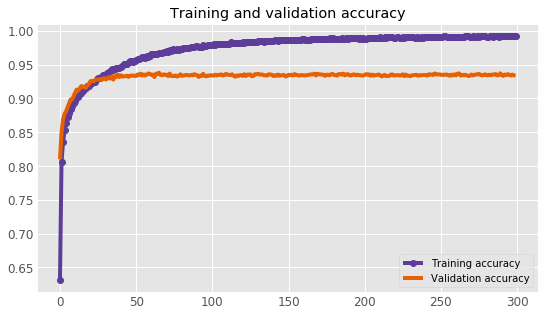

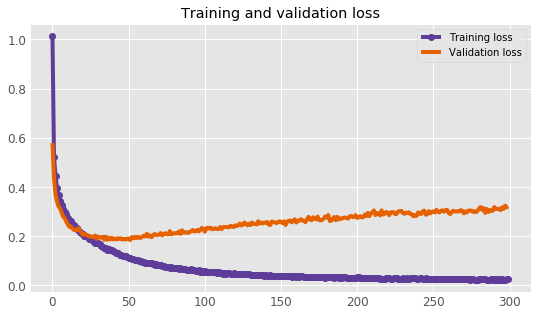

In [82]:
# plot training and validation accuracy
rt.plot_nn_training_curve(cnn_hist,f'{imageDir}cnn_training_curve')

### Model Evaluate & Prediction


In [83]:
#get the predictions for the test data
x_t = X_test[0].reshape(28,28)

In [84]:
# CNN predicted class accuracy
t = 0.0
y_test_pred = None
with rt.elapsed_timer() as elapsed:
    y_test_pred = cnn.predict_classes(X_test)

correct = np.nonzero(y_test_pred==y_test_labels)[0]
incorrect = np.nonzero(y_test_pred!=y_test_labels)[0]

modelsPerformance['PredictTime'].append(t)

In [85]:
print(f'{correct.size}, {incorrect.size}')
print(y_test_pred[:10])
print(y_test_labels[:10])

9314, 686
[9 2 1 1 6 1 4 6 5 7]
[9 2 1 1 6 1 4 6 5 7]


In [86]:
# Test Prediction Accuracy
cnn_test_pred_table = pd.DataFrame({'True_Test_Labels':y_test_labels, 'Predicted_Test_Labels':y_test_pred})
if sh_logger.info: print(f'Test Prediction shape: {cnn_test_pred_table.shape}')
if sh_logger.debug: print(f'Test Prediction Table Head:\n{cnn_test_pred_table.head()}')
    
# make table of miss labeled images
cnn_missLabeledTestImages = cnn_test_pred_table.loc[~(cnn_test_pred_table['True_Test_Labels'] == cnn_test_pred_table['Predicted_Test_Labels'])]
if sh_logger.info: print(f'Test Prediction Miss Labeled shape: {cnn_missLabeledTestImages.shape}')
if sh_logger.debug: print(f'Test Prediction Miss Labeled Head:\n{cnn_missLabeledTestImages.head()}')

# percent accuracy of labeled images
predictAccuracyScore = 100 - (cnn_missLabeledTestImages.shape[0]/cnn_test_pred_table.shape[0]*100)
if sh_logger.info: print(f'Test Prediction Error: {cnn_missLabeledTestImages.shape[0]/cnn_test_pred_table.shape[0]*100}%')
if sh_logger.info: print(f'Test Prediction Accuracy: {predictAccuracyScore}%')
    
targetNames = ["Class{}".format(i) for i in range(num_classes)]
if sh_logger.info: print(f'\n{classification_report(y_test_labels, y_test_pred, target_names=targetNames)}')   

modelsPerformance['PredictAccuracyScore'].append(predictAccuracyScore/100)

Test Prediction shape: (10000, 2)
Test Prediction Table Head:
   True_Test_Labels  Predicted_Test_Labels
0                 9                      9
1                 2                      2
2                 1                      1
3                 1                      1
4                 6                      6
Test Prediction Miss Labeled shape: (686, 2)
Test Prediction Miss Labeled Head:
    True_Test_Labels  Predicted_Test_Labels
12                 7                      5
23                 9                      5
25                 4                      2
42                 3                      0
43                 7                      9
Test Prediction Error: 6.859999999999999%
Test Prediction Accuracy: 93.14%

              precision    recall  f1-score   support

      Class0       0.86      0.89      0.88      1000
      Class1       1.00      0.99      0.99      1000
      Class2       0.90      0.90      0.90      1000
      Class3       0.93      0.95      0.94

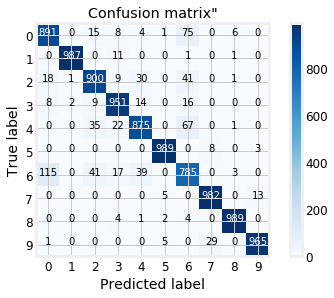

In [87]:
# confusion matrix evaluation
cm = confusion_matrix(cnn_test_pred_table.iloc[:,0],cnn_test_pred_table.iloc[:,1], labels=[0,1,2,3,4,5,6,7,8,9])
rt.plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7,8,9], f'{imageDir}cnn_confusion_matrix.png')

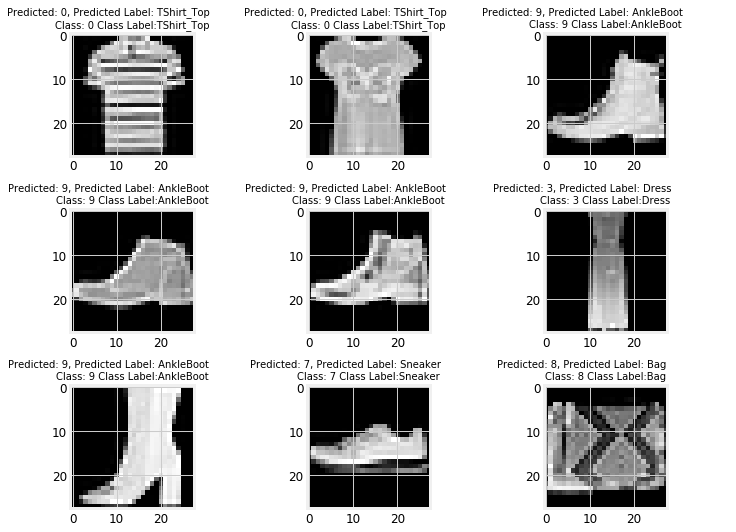

<Figure size 432x288 with 0 Axes>

In [88]:
# sample plot of correctly predicted images
plt.figure(figsize=(10, 7.5))
#fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
#ax = ax.flatten()
for i, cor in enumerate(np.random.choice(correct,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[cor].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {y_test_pred[cor]}, Predicted Label: {class_to_label[y_test_pred[cor]]} \
              \nClass: {y_test_labels[cor]} Class Label:{class_to_label[y_test_labels[cor]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}cnn_sample_correct_images.png', dpi=300)
plt.show()    
plt.tight_layout()
plt.show();

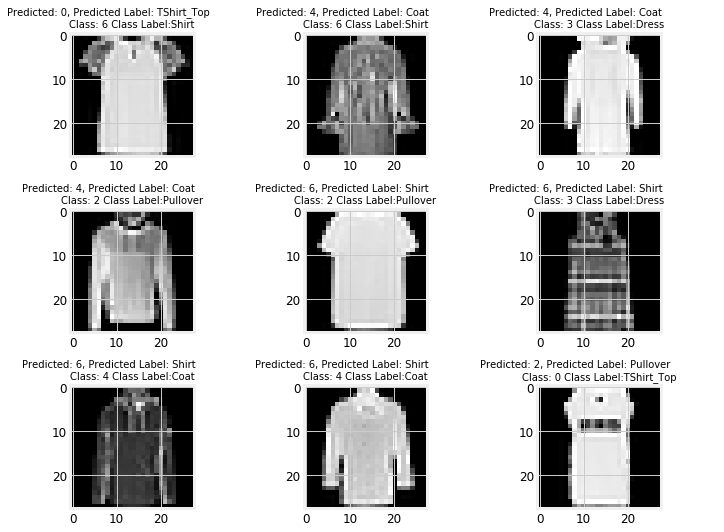

<Figure size 432x288 with 0 Axes>

In [89]:
# plot sample of incorrect
plt.figure(figsize=(10, 7.5))
for i, inc in enumerate(np.random.choice(incorrect,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[inc].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {y_test_pred[inc]}, Predicted Label: {class_to_label[y_test_pred[inc]]} \
              \nClass: {y_test_labels[inc]} Class Label:{class_to_label[y_test_labels[inc]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}cnn_sample_incorrect_images.png', dpi=300)
plt.show()    
plt.tight_layout()
plt.show();

In [ ]:
modelsPerformance['PredictAccuracyScore'] = [0.8974, 0.9314]

In [ ]:
modelsPerformance['TestTime'] = [0.0,0.0]
mp = pd.DataFrame(modelsPerformance)
mp.to_csv(f'{dataDir}nn_model_performanc.csv', index=False)

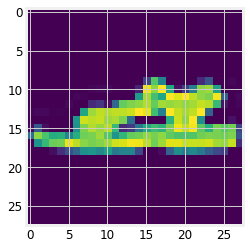

In [90]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

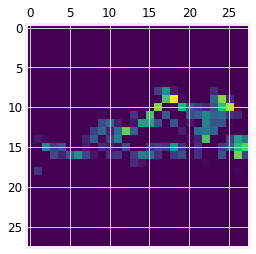

In [91]:
from keras import models
layer_outputs = [layer.output for layer in cnn.layers[:8]]
activation_model = models.Model(input=cnn.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

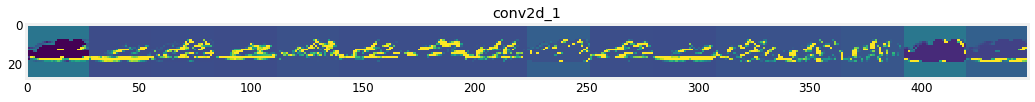

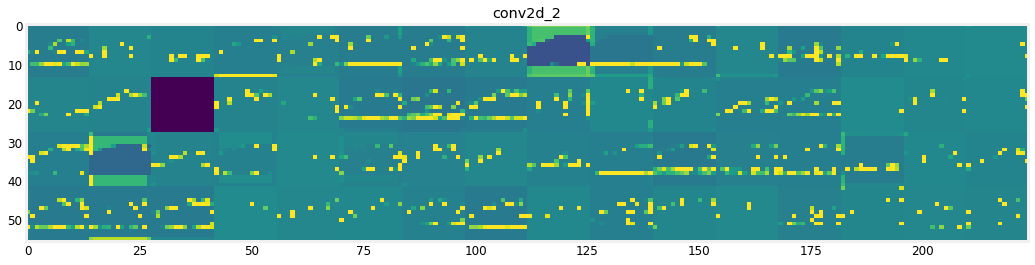

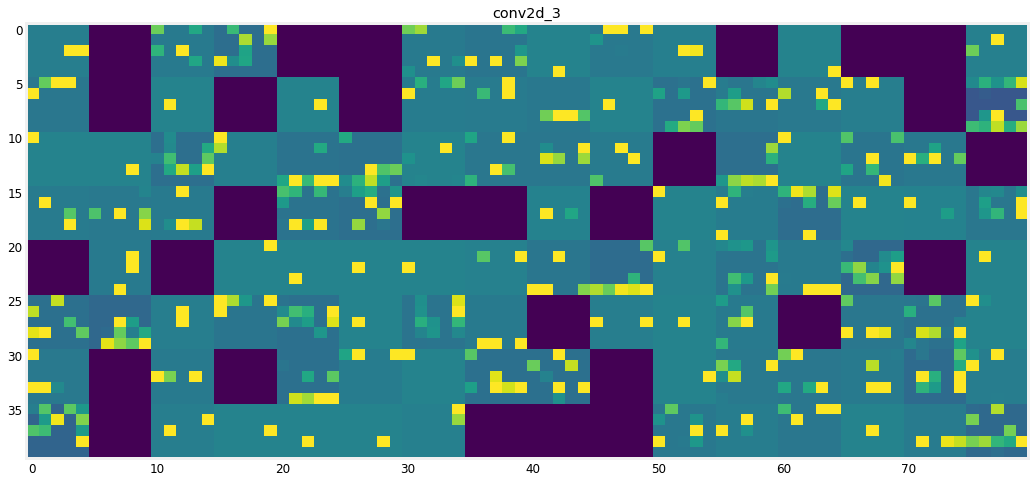

In [92]:
layer_names = []
for layer in cnn.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 5.0 Model Performance Comparison

In [93]:
mp1 = pd.read_csv(f'{dataDir}models_performance.csv')
mp2 = pd.read_csv(f'{dataDir}nn_model_performanc.csv')

# join performance dataframes
mp = pd.concat([mp1,mp2])
mp['TotalTime'] = mp['TrainTime']+mp['ScoreTime']+mp['PredictTime']+mp['TestTime']
mp    

,ModelName,TestAccuracyScore,PredictAccuracyScore,TrainTime,TestTime,ScoreTime,PredictTime,TotalTime
0,rf_base,0.880667,0.8726,84.922047,0.641522,0.000000,0.533718,86.097286
1,rf_base_cv,0.883280,0.8733,59.931356,0.000000,0.987812,0.520665,61.439834
2,rf_tun_1,0.851000,0.8435,25.983807,0.433044,0.000000,0.446281,26.863133
3,xgbc_base,0.868833,0.8609,654.543446,0.609808,0.000000,0.761276,655.914530
4,xgbs_gs,0.896167,0.8867,25462.346012,1.900499,0.000000,2.652688,25466.899199
0,nn_base,0.897400,0.8974,676.836291,0.000000,0.612764,0.000000,677.449054
1,CNN,0.931400,0.9314,24986.739215,0.000000,4.584205,0.000000,24991.323420


In [94]:
# view models by accuracy score
mp.sort_values(by='PredictAccuracyScore', ascending=False)

,ModelName,TestAccuracyScore,PredictAccuracyScore,TrainTime,TestTime,ScoreTime,PredictTime,TotalTime
1,CNN,0.931400,0.9314,24986.739215,0.000000,4.584205,0.000000,24991.323420
0,nn_base,0.897400,0.8974,676.836291,0.000000,0.612764,0.000000,677.449054
4,xgbs_gs,0.896167,0.8867,25462.346012,1.900499,0.000000,2.652688,25466.899199
1,rf_base_cv,0.883280,0.8733,59.931356,0.000000,0.987812,0.520665,61.439834
0,rf_base,0.880667,0.8726,84.922047,0.641522,0.000000,0.533718,86.097286
3,xgbc_base,0.868833,0.8609,654.543446,0.609808,0.000000,0.761276,655.914530
2,rf_tun_1,0.851000,0.8435,25.983807,0.433044,0.000000,0.446281,26.863133


In [95]:
# view models by Total Compute Time
mp.sort_values(by=['TotalTime', 'PredictAccuracyScore'],ascending=True)

,ModelName,TestAccuracyScore,PredictAccuracyScore,TrainTime,TestTime,ScoreTime,PredictTime,TotalTime
2,rf_tun_1,0.851000,0.8435,25.983807,0.433044,0.000000,0.446281,26.863133
1,rf_base_cv,0.883280,0.8733,59.931356,0.000000,0.987812,0.520665,61.439834
0,rf_base,0.880667,0.8726,84.922047,0.641522,0.000000,0.533718,86.097286
3,xgbc_base,0.868833,0.8609,654.543446,0.609808,0.000000,0.761276,655.914530
0,nn_base,0.897400,0.8974,676.836291,0.000000,0.612764,0.000000,677.449054
1,CNN,0.931400,0.9314,24986.739215,0.000000,4.584205,0.000000,24991.323420
4,xgbs_gs,0.896167,0.8867,25462.346012,1.900499,0.000000,2.652688,25466.899199


In [96]:
model_f1scores = pd.read_csv(f'{dataDir}models_f1score_classes.csv', keep_default_na=False)
model_f1scores

,Model,Class0,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9
0,CNN,0.88,0.99,0.90,0.94,0.89,0.99,0.79,0.97,0.99,0.97
1,nn_base,0.84,0.98,0.82,0.90,0.83,0.97,0.73,0.96,0.97,0.96
2,xgbs_gs,0.84,0.98,0.80,0.90,0.81,0.97,0.67,0.95,0.97,0.96
3,xgbs_base,0.82,0.97,0.76,0.86,0.77,0.96,0.61,0.93,0.96,0.94
4,rf_tun_1,0.82,0.98,0.74,0.86,0.75,0.95,0.60,0.91,0.96,0.93
5,rf_base,0.83,0.97,0.78,0.88,0.78,0.97,0.64,0.94,0.96,0.95
6,,,,,,,,,,,


In [97]:
'''
# Takes in model scores and plots them on a bar graph
'''
def plot_metric(model_scores, score='PredictAccuracyScore'):
    #import time
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    
    rcParams['figure.figsize'] = 7,5
    if score == 'TotalTime': 
        plt.bar(model_scores['ModelName'], height=np.log(model_scores[score]))
    else:
        plt.bar(model_scores['ModelName'], height=model_scores[score])
    
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,7)]
    xlabs=[i for i in range(0,7)]
    
    if(score != 'TotalTime'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
        
            
    plt.xlabel('Model')
    plt.ylabel(f'{score}_log')
    plt.xticks(rotation=45)
    plt.show()

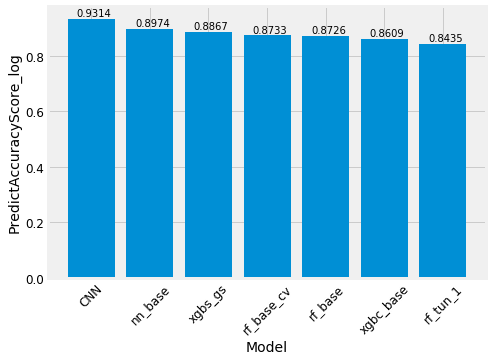

<Figure size 504x360 with 0 Axes>

In [98]:
# plot model scores
plot_metric(mp.sort_values(by='PredictAccuracyScore', ascending=False))
plt.savefig(f'{imageDir}models_accuracy_metrics.png', dpi=300)

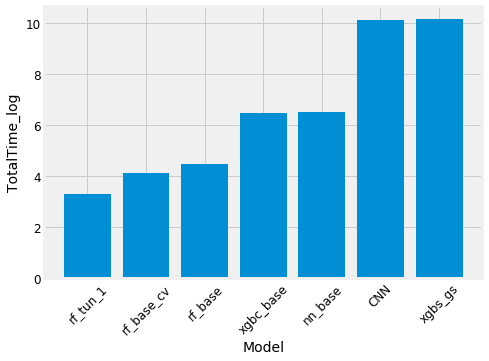

<Figure size 504x360 with 0 Axes>

In [99]:
# plot model Total Compute Time log value
plot_metric(mp.sort_values(by=['TotalTime', 'PredictAccuracyScore'],ascending=True), score='TotalTime')
plt.savefig(f'{imageDir}models_accuracy_metrics.png', dpi=300)

### iNterpret
Interpret the model results, make knowledge based recommendations